<a href="https://colab.research.google.com/github/ShaokangYANG/IMDB/blob/main/Project_2_IMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download dataset frome Kaggle

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mountainsky","key":"210d17aaec699030b82766a96422d60c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.43G/1.44G [00:12<00:00, 127MB/s]
100% 1.44G/1.44G [00:12<00:00, 126MB/s]


### 2. Unzip files
Get all the files in the compressed package

Unzip files in a loop to the specified directory

Close the file and free up memory


In [3]:
from zipfile import ZipFile
file_name = "imdb-dataset.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("The dataset has been unzipped")

The dataset has been unzipped


In [4]:
!ls

imdb-dataset.zip    title.akas.tsv	  title.principals.tsv.gz
kaggle.json	    title.akas.tsv.gz	  title.ratings.tsv
name.basics.tsv     title.basics.tsv	  title.ratings.tsv.gz
name.basics.tsv.gz  title.basics.tsv.gz
sample_data	    title.principals.tsv


In [5]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 45kB/s 
     |████████████████████████████████| 204kB 19.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=9db73bd2d06d66f2dd124f4041b58636a0e9a5585a3dd2e8bde78a6faa8bd57f
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


Print all tsv files

In [6]:
import os
all_files = os.listdir()
print([csv_file for csv_file in all_files if '.tsv' == csv_file[-4:]])

['name.basics.tsv', 'title.basics.tsv', 'title.principals.tsv', 'title.ratings.tsv', 'title.akas.tsv']


### 3. Load data & Overview

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col, count
from pyspark.sql import SQLContext

In [8]:
conf = SparkConf().setAppName("MarketBasket")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '45G')
        .set('spark.default.parallelism',24)
        .set('spark.driver.maxResultSize', '10G'))
sc = SparkContext(conf=conf)

In [9]:
name_basics = 'name.basics.tsv.gz'
name_basics = pd.read_csv(name_basics, sep = '\t', low_memory=True)

title_akas = 'title.akas.tsv.gz'
title_akas = pd.read_csv(title_akas, sep = '\t', low_memory=True)

title_basics ='title.basics.tsv.gz'
title_basics = pd.read_csv(title_basics, sep = '\t', low_memory=True)

title_principals='title.principals.tsv.gz'
title_principals = pd.read_csv(title_principals,sep = '\t', low_memory=True)

title_rating='title.ratings.tsv.gz'
title_rating = pd.read_csv(title_rating, sep = '\t', low_memory=True)


In [10]:
print('Shape, Columns: \n')
print('name_basics: {}, \n{} \n'.format(name_basics.shape, name_basics.columns))
print('title_akas: {}, \n{} \n'.format(title_akas.shape, title_akas.columns))
print('title_basics: {}, \n{} \n'.format(title_basics.shape, title_basics.columns))
print('title_principals: {}, \n{} \n'.format(title_principals.shape, title_principals.columns))
print('title_rating: {}, \n{} \n'.format(title_rating.shape, title_rating.columns))

Shape, Columns: 

name_basics: (9711022, 6), 
Index(['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object') 

title_akas: (19344171, 8), 
Index(['titleId', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle'],
      dtype='object') 

title_basics: (6326545, 9), 
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object') 

title_principals: (36499704, 6), 
Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object') 

title_rating: (993821, 3), 
Index(['tconst', 'averageRating', 'numVotes'], dtype='object') 



### 4. Data Analytics in Macro Level
Table 'name_basics' contains information about the personnel involved, including nconst, primaryName, birthYear, deathYear, primaryProfession, knownForTitles.

First calculate how many functions there are and draw a picture

In [11]:
import matplotlib.pyplot as plt

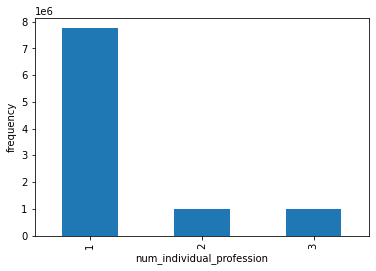

In [12]:
def name_basics_func0():
    primaryProfession = name_basics['primaryProfession'].dropna()
    name_basics['primaryProfession'] = name_basics['primaryProfession'].astype('str')
    num_individual_profession = name_basics['primaryProfession'].map(lambda x: len(x.split(',')))
    name_basics['num_individual_profession'] = num_individual_profession
    name_basics['num_individual_profession'].value_counts().plot(kind='bar')
    plt.xlabel('num_individual_profession')
    plt.ylabel('frequency')
    plt.show()
    new_name_basics0 = name_basics[['birthYear', 'num_individual_profession']]
    return new_name_basics0

new_name_basics0 = name_basics_func0()

In [13]:
! pip install apyori
from apyori import apriori

  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=90e4930777ebf6b7b13524e3446463651363284f4a840bb58265c47c0c6a4141
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


Calculate and plot the frequency of various occupations

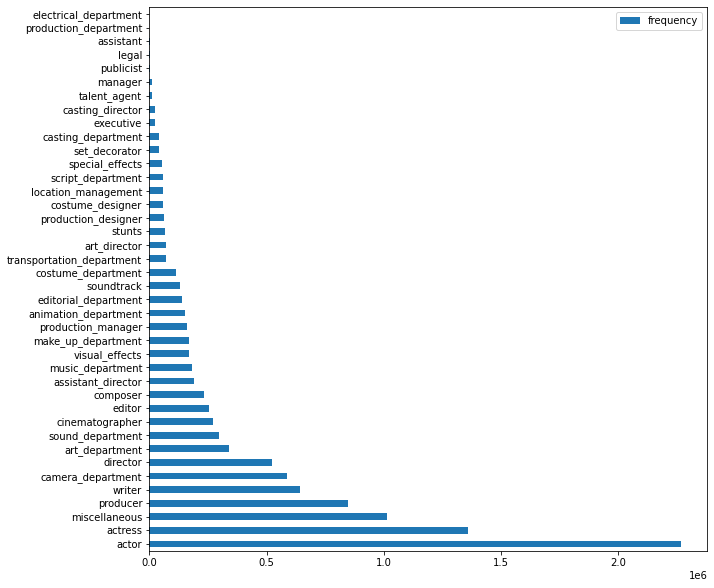

Aprior
RelationRecord(items=frozenset({'actor'}), support=0.29146703106806504, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'actor'}), confidence=0.29146703106806504, lift=1.0)])
RelationRecord(items=frozenset({'actress'}), support=0.17475387990800134, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'actress'}), confidence=0.17475387990800134, lift=1.0)])
RelationRecord(items=frozenset({'miscellaneous'}), support=0.1301110227651442, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'miscellaneous'}), confidence=0.1301110227651442, lift=1.0)])
RelationRecord(items=frozenset({'producer'}), support=0.1090734250988492, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'producer'}), confidence=0.1090734250988492, lift=1.0)])


In [14]:
def name_basics_func1():
    frequency_profession_dict = dict()
    for primaryProfession in name_basics['primaryProfession']:
        for pro in primaryProfession.split(','):
            if pro == 'nan':
                continue
            try:
                frequency_profession_dict[pro] += 1
            except KeyError:
                frequency_profession_dict[pro] = 1

    frequency_profession_df = pd.DataFrame(frequency_profession_dict.values(),
                                           index=frequency_profession_dict.keys(),
                                           columns=['frequency']).sort_values('frequency', ascending=False)
    frequency_profession_df.plot(kind='barh', figsize=(10, 10))
    plt.show()
    
    res = apriori(name_basics[name_basics['primaryProfession'] != 'nan']['primaryProfession'].map(lambda x: x.split(',')).values)
    print('Aprior')
    for rule in res:
        print(str(rule))
    return frequency_profession_df
    
    
frequency_profession_df = name_basics_func1()

In table title_basics, We can get more information about the genre, and we can also know the productivity of works in each era.

The following are the different kinds of quantities


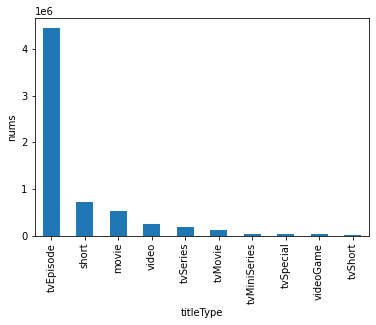

The earliest work was created in 1874, and the latest will be in 2115
From 1880 to 2020, the number of works per ten years is as follows:


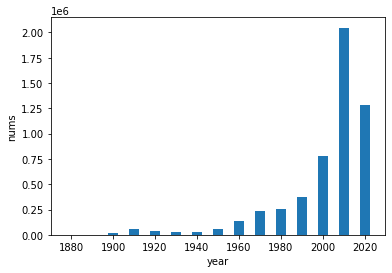

In [16]:
def title_basics_func0():
    title_basics['titleType'].value_counts().plot(kind='bar')
    plt.xlabel('titleType')
    plt.ylabel('nums')
    print('The following are the different kinds of quantities')
    plt.show()

    _title_basics = title_basics[title_basics['startYear'] != '\\N']
    _title_basics.loc[:, 'startYear'] = _title_basics.startYear.astype('int')
    earest_year = _title_basics.startYear.min()
    latest_year = _title_basics.startYear.max()
    print('The earliest work was created in {}, and the latest will be in {}'.format(earest_year, latest_year))

    print('From 1880 to 2020, the number of works per ten years is as follows:')
    years = np.arange(1880, 2021, 10)
    nums = [len(_title_basics[(year - 5) < _title_basics['startYear']][_title_basics['startYear'] < (year + 5)]) for year in years]
    plt.bar(years, nums, width=5)
    plt.xlabel('year')
    plt.ylabel('nums')
    plt.show()
    
    title_basics.loc[title_basics['runtimeMinutes'] == '\\N', 'runtimeMinutes'] = 0
    new_title_basics = title_basics[['tconst', 'startYear', 'runtimeMinutes']]
    return new_title_basics
    
new_title_basics = title_basics_func0()

Frequency Statistic

In [18]:
for i in range(10):
    print(i + 1)
    print(list(tconst_nconst_dict.keys())[i])
    print(list(tconst_nconst_dict.values())[i])

print('...')
print('A total of {} pieces of valid data'.format(len(tconst_nconst_dict)))

1
Carmencita
['Carmencita', 'William K.L. Dickson', 'William Heise']
2
Le clown et ses chiens
['Émile Reynaud', 'Gaston Paulin']
3
Pauvre Pierrot
['Émile Reynaud', 'Julien Pappé', 'Gaston Paulin', 'Tamara Pappé']
4
Un bon bock
['Émile Reynaud', 'Gaston Paulin']
5
Blacksmith Scene
['Charles Kayser', 'John Ott', 'William K.L. Dickson', 'Thomas A. Edison', 'Louis Lumière']
6
Chinese Opium Den
['William K.L. Dickson']
7
Corbett and Courtney Before the Kinetograph
['James J. Corbett', 'Peter Courtney', 'William K.L. Dickson', 'William Heise', 'Thomas A. Edison']
8
Edison Kinetoscopic Record of a Sneeze
['Fred Ott', 'William K.L. Dickson', 'William Heise']
9
Miss Jerry
['Blanche Bayliss', 'William Courtenay', 'Chauncey Depew', 'Alexander Black']
10
Exiting the Factory
['Louis Lumière']
...
A total of 326181 pieces of valid data


In [20]:
nconst_dict = dict()
for nconst in title_principals['nconst'].values:
    try:
        nconst_dict[nconst] += 1
    except KeyError:
        nconst_dict[nconst] = 1

In [21]:
nconst_df = pd.DataFrame()
nconst_df['nconst'] = nconst_dict.keys()
nconst_df['frequency'] = nconst_dict.values()

In [22]:
print('The ten most frequently appearing actors are as follows:')
i = 0
for nconst in nconst_df.sort_values('frequency', ascending=False).nconst.values:
    profession = name_basics[name_basics['nconst'] == nconst].primaryProfession.item()
    if ('actor' in profession) or ('actress' in profession):
        i += 1
        name = name_basics[name_basics['nconst'] == nconst].primaryName.item()
        freq = nconst_df[nconst_df['nconst'] == nconst].frequency.item()
        print('Rank: {}, Name: {}. Freq: {} times'.format(i, name, freq))
        if i == 10:
            break

The ten most frequently appearing actors are as follows:
Rank: 1, Name: Tony Warren. Freq: 9892 times
Rank: 2, Name: Johnny Gilbert. Freq: 8536 times
Rank: 3, Name: Ernesto Alonso. Freq: 8415 times
Rank: 4, Name: Delia Fiallo. Freq: 8408 times
Rank: 5, Name: Alex Trebek. Freq: 8022 times
Rank: 6, Name: Lee Phillip Bell. Freq: 7482 times
Rank: 7, Name: Henrique Martins. Freq: 7182 times
Rank: 8, Name: Pat Sajak. Freq: 7079 times
Rank: 9, Name: Bob Barker. Freq: 7004 times
Rank: 10, Name: Johnny Olson. Freq: 6945 times


###5.Market Basket Analysis
####5.1 Data Preparation

**title_basics contains the movie information**

In [ ]:
sqlContext = SQLContext(sc)

title_basics = 'title.basics.tsv.gz'
title_basics = sqlContext.read.csv(title_basics, header=True, sep = '\t')
title_basics.show(10) # see what the table looks like originally

# there are 'short' 'video' in titleType, keep 'movie' only
title_basics = title_basics.filter((title_basics.titleType == "movie"))
title_basics.show(10) # see what the table looks like after filtering

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

***names.basic contains the actors information***

In [ ]:
name_basics = 'name.basics.tsv.gz'
name_basics = sqlContext.read.csv(name_basics, header=True, sep = '\t')
name_basics.show(10) # see what the table looks like 

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0117057,tt00373...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0049189,tt00599...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0078723,tt00804...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00839...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0077711,tt00387...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0033870,tt00373...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0078788,tt00708...|
|nm0000009

***title_principals contains the principal cast/crew for titles, which is necessary to extract movie and actors information.***

In [ ]:
title_principals = 'title.principals.tsv.gz'
title_principals = sqlContext.read.csv(title_principals, header=True, sep = '\t')
title_principals.show(10) # see what the table looks like originally

title_principals = title_principals.filter((title_principals.category == "actor") | (title_principals.category == "actress")) # keep only actor and actress
title_principals = title_principals.select(col("tconst"),col("nconst")) # select movie id and actor id 
title_principals.show(10) # see what the table looks like after filtering

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

In [ ]:
title_principals = title_principals.join(title_basics, ["tconst"])
title_principals.show(10) # print example

+---------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+
|   tconst|   nconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+---------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+
|tt0002591|nm0029806|    movie|             Zu spät|             Zu spät|      0|     1912|     \N|            \N|    \N|
|tt0002591|nm0509573|    movie|             Zu spät|             Zu spät|      0|     1912|     \N|            \N|    \N|
|tt0003689|nm0694718|    movie|          Born Again|          Born Again|      0|     1914|     \N|            \N| Drama|
|tt0003689|nm0101071|    movie|          Born Again|          Born Again|      0|     1914|     \N|            \N| Drama|
|tt0003689|nm0910564|    movie|          Born Again|          Born Again|      0|     1914|     \N|            \N| Drama|
|tt0003689|nm0527801|   

Now I have three tables: title_basics with only movie information, name_basics with only actor informaiton, title_principals with information of principal cast in a movie.

####5.2A-prior Algorithm 

In [ ]:
import itertools

In [ ]:
def sum(a,b):
  return a+b

# To see if a set of items is a subset of a basket.
def check_subset(rddlist, filt):
  for item in filt:
    if set(list(item)).issubset(set(rddlist)):
      return ((item, 1))

In [ ]:
def apriori(rdd, threshold):
  
  flat_list  = rdd.flatMap(list) 

  singleton = flat_list.map(lambda item: (item , 1)) #Everytime when each actor appearences, add 'one'
  singleton_summed = singleton.reduceByKey(sum) #Sum of values by actor as key
  singleton_filtered = singleton_summed.filter(lambda item: item[1] >= threshold ) #consider items that appear singularly in a certain number of time that is larger than the threshold in the baskets.

  #Acquire a list of the codes of the items
  frequent_actors = singleton_filtered.map(lambda item: (item[0]))

  #Acquire all the pairs of frequent items:
  pairs_list = list(itertools.combinations(frequent_actors.toLocalIterator(),2))

  #Make the support table for the pairs of items by applying the filtering function previously created.
  support_table_pairs = rdd.map(lambda x : check_subset(x, pairs_list)).filter(lambda x: x is not None).cache() #Use filtering function to check if a pairs appear in the movies
  support_table_pairs_summed = support_table_pairs.reduceByKey(sum) # sum of values by actor as key
  support_table_pairs_filtered = support_table_pairs_summed.filter(lambda item: item[1] >= threshold) #Check the situation when only actor that performed in more than support value

  return (support_table_pairs_filtered)

####5.3 SON Algorithm Implementation and Result

In [ ]:
#Make a list containing baskets: each movie is a basket and it is a list containing the actors that performed in that film
baskets = title_principals.groupBy("tconst").agg(collect_set("nconst").alias("actors"))

#Acquire the list of baskets containing actors divided by movies
basket_list = baskets.select('actors').rdd.flatMap(list)

#Parallelize the list in RDD
basket_list = sc.parallelize(basket_list.collect(),10)

print(basket_list.collect()[:10]) #print example of ten lists

[['nm0029806', 'nm0509573'], ['nm0910564', 'nm0527801', 'nm0399988', 'nm0101071', 'nm0694718', 'nm0728289', 'nm0585503'], ['nm0368875', 'nm0092665', 'nm0492302', 'nm0445507', 'nm0776747', 'nm0383278', 'nm0192062', 'nm0285643', 'nm0793189'], ['nm0268437', 'nm0811293', 'nm0102718', 'nm0190516', 'nm0478359'], ['nm0593671', 'nm0394389', 'nm0203439', 'nm0909648', 'nm0863863', 'nm0269671'], ['nm0075601', 'nm0364218', 'nm0668525', 'nm0322794', 'nm0304236', 'nm0061746'], ['nm0606530', 'nm0493083'], ['nm0071601', 'nm0071618', 'nm0673814', 'nm0507655', 'nm0000909', 'nm0607056', 'nm0071992', 'nm0000910'], ['nm0356267', 'nm0235634', 'nm0285950', 'nm0183994', 'nm0135474', 'nm0512164'], ['nm0546121', 'nm0909648', 'nm0668084', 'nm0455748']]


In [ ]:
minSupport = 100
numPartitions = basket_list.getNumPartitions() #Set partition number (10)
adjSupport = minSupport/numPartitions
adjSupport

10.0

In [ ]:
candidates = sc.parallelize([]) #Make a RDD to merge the result of apriori applied on each chunk.

for i in range(0, numPartitions-1):
  
  partition = sc.parallelize(basket_list.glom().collect()[i]) #Collect every chunk
  support_table_pairs_filtered = apriori(partition, adjSupport)
  candidate_chunk = support_table_pairs_filtered.map(lambda item: (item[0],1))
  candidates = candidates.union(candidate_chunk)

In [ ]:
print(candidates.collect()[:10]) #print example, it can be time-consuming

[(('nm2384746', 'nm2366585'), 1), (('nm2373718', 'nm0648803'), 1), (('nm0409049', 'nm0289960'), 1), (('nm2373718', 'nm0648803'), 1), (('nm1984183', 'nm1990182'), 1), (('nm0355653', 'nm0329832'), 1), (('nm2373718', 'nm0648803'), 1), (('nm2384746', 'nm2366585'), 1), (('nm2373718', 'nm0648803'), 1), (('nm2373718', 'nm0648803'), 1)]


In [ ]:
#Find frequent items and convert the RDD to dataframe
deptColumns = ["actor_pair","movies"]
candidates_set = candidates.toDF(deptColumns)
candidates_set.createOrReplaceTempView("candidates_set")
sqlContext.sql("SELECT * FROM candidates_set ORDER BY movies DESC").show(truncate = False)

+----------------------+------+
|actor_pair            |movies|
+----------------------+------+
|{nm2384746, nm2366585}|1     |
|{nm2373718, nm0648803}|1     |
|{nm0409049, nm0289960}|1     |
|{nm2373718, nm0648803}|1     |
|{nm1984183, nm1990182}|1     |
|{nm0355653, nm0329832}|1     |
|{nm2373718, nm0648803}|1     |
|{nm2384746, nm2366585}|1     |
|{nm2373718, nm0648803}|1     |
|{nm2373718, nm0648803}|1     |
+----------------------+------+

